In [4]:
from fastai.vision.all import *

In [6]:
pwd

'C:\\Users\\hammad jamil\\Desktop'

In [33]:
import os
path=os.chdir('C:\\Users\\hammad jamil\\Desktop')

In [34]:
path=Path.cwd()
path

Path('C:/Users/hammad jamil/Desktop')

In [35]:
path=path/'car_data'
path.ls()

(#4) [Path('C:/Users/hammad jamil/Desktop/car_data/test'),Path('C:/Users/hammad jamil/Desktop/car_data/train'),Path('C:/Users/hammad jamil/Desktop/car_data/valid'),Path('C:/Users/hammad jamil/Desktop/car_data/_annotations.json')]

In [36]:
imgs, lbl_bbox = get_annotations(path/'_annotations.json')

In [37]:
imgs[0]


'0903_jpg.rf.081da3da5c508d33227db739d53725ff.jpg'

In [38]:
lbl_bbox[0]

([[250, 46, 321, 77],
  [250, 101, 324, 131],
  [252, 74, 323.5, 105.5],
  [247, 135, 321.5, 162],
  [248, 253, 321.5, 281],
  [360, 248, 380.5, 290],
  [372, 73, 395, 163.5],
  [395, 83, 415.5, 167.5],
  [321, 304, 335, 333],
  [318, 340, 333.5, 371],
  [30, 52, 53, 97]],
 ['9', '9', '9', '9', '9', '7', '9', '9', '7', '7', '4'])

In [39]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [40]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'0903_jpg.rf.081da3da5c508d33227db739d53725ff.jpg': ([[250, 46, 321, 77],
   [250, 101, 324, 131],
   [252, 74, 323.5, 105.5],
   [247, 135, 321.5, 162],
   [248, 253, 321.5, 281],
   [360, 248, 380.5, 290],
   [372, 73, 395, 163.5],
   [395, 83, 415.5, 167.5],
   [321, 304, 335, 333],
   [318, 340, 333.5, 371],
   [30, 52, 53, 97]],
  ['9', '9', '9', '9', '9', '7', '9', '9', '7', '7', '4'])}

In [41]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]


In [42]:
item_tfms = [Resize(128, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [43]:
def get_train_imgs(noop):  return imgs

In [64]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [65]:
dls = pascal.dataloaders(path/'train')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [96]:
dls.c =15

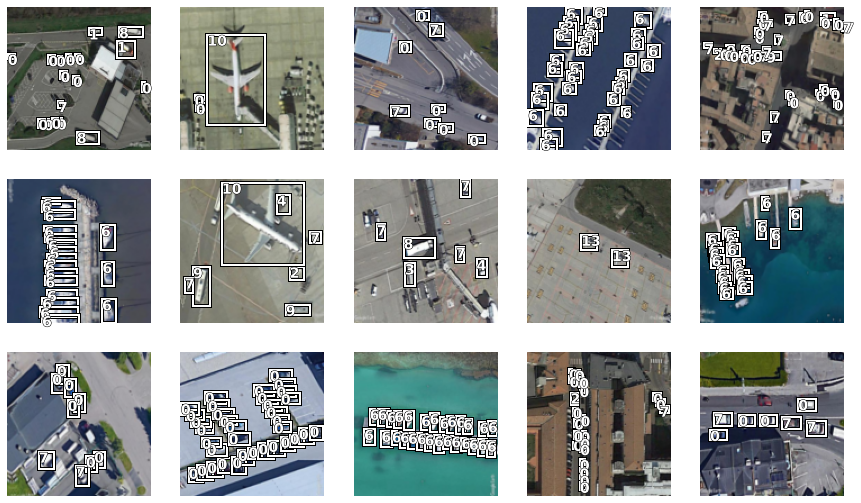

In [112]:
dls.show_batch(max_n=15)

In [99]:
from wwf.vision.object_detection import *

In [100]:
encoder = create_body(resnet34, pretrained=True)

In [101]:
get_c(dls)


15

In [102]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [103]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(248, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=248, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [104]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [105]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)


In [106]:
TensorImage.register_func(torch.nn.functional.smooth_l1_loss, TensorImage, TensorBBox)
TensorMultiCategory.register_func(TensorMultiCategory.mul, TensorMultiCategory, TensorImage)
TensorImage.register_func(torch.nn.functional.binary_cross_entropy_with_logits, TensorImage, TensorMultiCategory)

In [107]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [108]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)


In [109]:
learn.freeze()

In [110]:
learn.fit_one_cycle(2, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,2.954715,2.657612,26:41
1,2.712457,2.705695,19:33


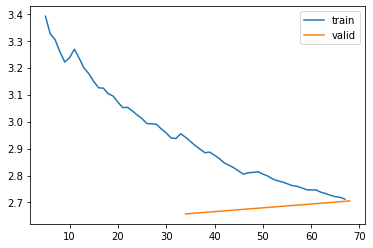

In [111]:
learn.recorder.plot_loss()